# Spatial Autocorrelation: Moran's I

This python notebook introduces global and local spatial autocorrelation, using the Moran's $I$ with [PySAL](https://pysal.org/). It uses an example previously presented by [Rey *et al.* (2020)](https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html#spatial-lag) and data therein.

Contents:
- <a href=#overview>Overview of Spatial Autocorrelation
- <a href=#moran>Overview of Moran's I
    - <a href=#global>Global Moran's I
- <a href=#lisa>Overview of Local Indicators of Spatial Association
    - <a href=#plot>The Moran's Plot</a>
    - <a href=#local>Local Moran's I</a>

# Autocorrelation Overview <a name="overview"></a>
Autocorrelation is correlation of a variable with its lagged self. In the sense used here, lag can be thought of as an offset, and when spatial autocorrelation is considered a lag is a distance across space. 

So, spatial autocorrelation is a quantitative measure of similarity between observations at different locations of a single variable. Contrast this *auto*correlation with normal correlation, which is a measure of similarity between observations of two variables at the same locations. 

Spatial autocorrelation provides a means to quantify the existence of Tobler's 'First Law' that,

> Everything is related to everything else, but near things are more related than distant things.

Tobler's First Law implies *positive* spatial autocorrelation, and we can think of observations of similar values as being clustered. The opposite - when distant things are more similar than near things - is known as *negative* spatial autocorrelation and we can thinking of observations of similar values as being dispersed. Negative spatial autocorrelation is quite rare in real world geographical observations. An *absence* of spatial autocorrelation implies there is no spatial structure and that a variable is distributed randomly across space. 

With respect to spatial autocorrelation, often in geography and spatial data science we want to know:

1. Is there *any* spatial structure? (i.e. can we say a variable is *not* randomly distributed?)
2. If there is spatial structure, what *type* is it? (i.e. positive or negative?) 
3. If there is spatial structure, how *strong* is it (i.e. how tightly clustered or broadly dispersed are values?)

Spatial statistics in spatial data science provide various tools to answer these questions, including the Joins Count test for spatial autocorrelation (examined in another notebook) and Moran's I (examined in this notebook). We can also consider spatial autocorrelation *globally* across and entire data set, or *locally* for individual observations.

[Section 2.2 of O'Sullivan and Unwin (2010)](https://ebookcentral.proquest.com/lib/kcl/reader.action?docID=4945124&ppg=58) provides further introduction to the concept of spatial autocorrelation, with [section 7.4](https://ebookcentral.proquest.com/lib/kcl/reader.action?docID=4945124&ppg=223) providing more detail. Also see [Rey *et al.* (2020)](https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html).

## Setup

First load required libraries

In [11]:
# Graphics
import matplotlib.pyplot as plt
from matplotlib import colors

# Analysis
import geopandas as gpd
import pandas as pd
from pysal.lib import weights
from pysal.explore import esda
import numpy as np

In ths notebook we'll used data for the results of the UK Brexit vote, as [provided](https://geographicdata.science/book/data/brexit/brexit_cleaning.html) by Rey *et al.* (2020). There are two distinct datasets that will need to be loaded and combined:

- Electoral Comission data on vote percentages at the local authority level. [CSV]
- ONS Local Authority Districts (December 2016) Generalised Clipped Boundaries in the UK WGS84. 

First load the vote percentage data as a pandas df:

In [12]:
brexit_data_path = '../../data/brexit/brexit_vote.csv'
ref = pd.read_csv(brexit_data_path, index_col='Area_Code')
ref.head()

,id,Region_Code,Region,Area,Electorate,ExpectedBallots,VerifiedBallotPapers,Pct_Turnout,Votes_Cast,Valid_Votes,Remain,Leave,Rejected_Ballots,No_official_mark,Voting_for_both_answers,Writing_or_mark,Unmarked_or_void,Pct_Remain,Pct_Leave,Pct_Rejected
Area_Code,,,,,,,,,,,,,,,,,,,,
E06000031,108,E12000006,East,Peterborough,120892,87474,87469,72.35,87469,87392,34176,53216,77,0,32,7,38,39.11,60.89,0.09
E06000032,109,E12000006,East,Luton,127612,84633,84636,66.31,84616,84481,36708,47773,135,0,85,0,50,43.45,56.55,0.16
E06000033,112,E12000006,East,Southend-on-Sea,128856,93948,93939,72.90,93939,93870,39348,54522,69,0,21,0,48,41.92,58.08,0.07
E06000034,113,E12000006,East,Thurrock,109897,79969,79954,72.75,79950,79916,22151,57765,34,0,8,3,23,27.72,72.28,0.04
E06000055,110,E12000006,East,Bedford,119530,86136,86136,72.06,86135,86066,41497,44569,69,0,26,1,42,48.22,51.78,0.08


Next load the local authority district boundaries as a geopandas geodf:

In [13]:
lads = gpd.read_file("../../data/brexit/local_authority_districts.geojson").set_index('lad16cd')
lads.head()

,objectid,lad16nm,lad16nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
lad16cd,,,,,,,,,,
E06000001,1,Hartlepool,None,447157,531476,-1.27023,54.676159,0.013041,0.879421,"MULTIPOLYGON (((-1.27024 54.72716, -1.38088 54..."
E06000002,2,Middlesbrough,None,451141,516887,-1.21099,54.544670,0.007484,0.535764,"MULTIPOLYGON (((-1.23001 54.58410, -1.28158 54..."
E06000003,3,Redcar and Cleveland,None,464359,519597,-1.00611,54.567520,0.034014,1.266847,"MULTIPOLYGON (((-1.13716 54.64693, -1.13256 54..."
E06000004,4,Stockton-on-Tees,None,444937,518183,-1.30669,54.556911,0.028479,1.424195,"MULTIPOLYGON (((-1.31774 54.64524, -1.38088 54..."
E06000010,10,"Kingston upon Hull, City of",None,511894,431716,-0.30380,53.769791,0.009740,0.782168,"MULTIPOLYGON (((-0.31613 53.81325, -0.35366 53..."


And then `join` the df to the geodf (the two df have the same index, using local autority district codes) and select only the columns we need for the analysis:

In [14]:
gdf = gpd.GeoDataFrame(lads.join(ref[['Pct_Leave']]), crs=lads.crs)
gdf = gdf[['objectid', 'lad16nm', 'Pct_Leave', 'geometry']].dropna()
gdf.head()

,objectid,lad16nm,Pct_Leave,geometry
lad16cd,,,,
E06000001,1,Hartlepool,69.57,"MULTIPOLYGON (((-1.27024 54.72716, -1.38088 54..."
E06000002,2,Middlesbrough,65.48,"MULTIPOLYGON (((-1.23001 54.58410, -1.28158 54..."
E06000003,3,Redcar and Cleveland,66.19,"MULTIPOLYGON (((-1.13716 54.64693, -1.13256 54..."
E06000004,4,Stockton-on-Tees,61.73,"MULTIPOLYGON (((-1.31774 54.64524, -1.38088 54..."
E06000010,10,"Kingston upon Hull, City of",67.62,"MULTIPOLYGON (((-0.31613 53.81325, -0.35366 53..."


Let's quickly visualise the leave vote percentage data:

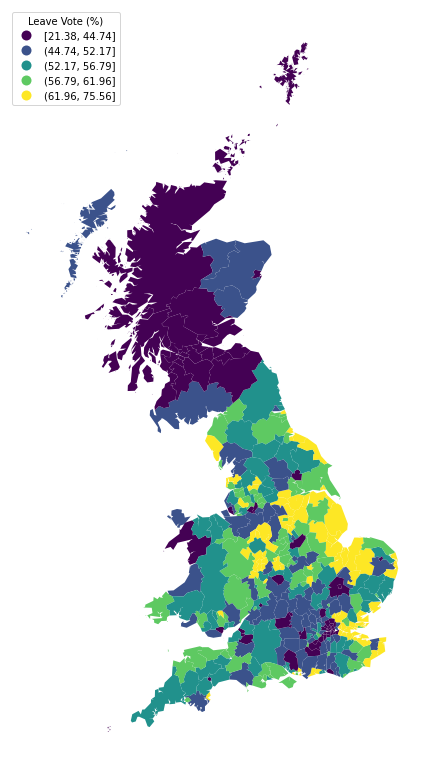

In [15]:
fig, ax = plt.subplots(1, figsize=(14, 14))
gdf.plot(column='Pct_Leave', cmap='viridis', 
        scheme='quantiles', k=5, 
        linewidth=0., 
        legend=True, legend_kwds={"title":"Leave Vote (%)","loc": 2},
        ax=ax
       )
ax.set_axis_off()

# Moran's I Overview <a name="moran"></a>

One of the most widely used measures of spatial autocorrelation is Moran’s I, which is a translation of non-spatial correlation (for two continuous variables at the same locations) into a spatial context (for one continuous variable at different locations).

Essentially, Moran’s $I$ is the correlation coefficient for the relationship between the values of a variable and the spatially lagged local mean values. The concept of a spatially lagged local mean is covered in another notebook.   

The equation for Moran's $I$ might seem quite intimidating:

$$
I = \dfrac{n}{\sum_i\sum_j w_{ij}} \dfrac{\sum_i\sum_j w_{ij} \, z_i \, z_j}{\sum_i z_i^2}
$$

But as O'Sullivan and Unwin (2010) do [from page 205](https://ebookcentral.proquest.com/lib/kcl/reader.action?docID=4945124&ppg=229), we can break this down to understand a little better what's going on. 

Remember that in mathematical notation the $\sum$ (greek upper-case sigma) means 'sum' and that placing two items next to one another means they should be multiplied together. So the first main thing to notice about the equation for Moran's $I$ is that it is two fractions multiplied together. 

Next, we can define what all the letters mean:
- $n$ is the number of observations (i.e. locations) in our data set
- $z_i$ is the standardized value of our variable at location *i*
- $z_j$ is the standardized value of our variable at location *j*
- $w_{ij}$ is the value in the weights matrix for the relationship between locations *i* and *j* (i.e. the number in the *i*-th row and the *j*-th column)

Remember that the standardised value *z* of a variable *y* is given by:

$$
\frac{(y-\bar{y})}{\sigma_y}
$$

where $\bar{y}$ is *the mean of $y$* and $\sigma_y$ is *the standard deviation of $y$*. 

The numerator on top of the second fraction is the important bit as this is what is essentially calculating the autocorrelation. Everything else is normalizing $I$ so that its value falls between -1 and +1. Similar to Pearson's $r$ for non-spatial correlation, a value near +1 means strong positive autocorrelation and a value near -1 means strong negative correlation. However, as O'Sullivan and Unwin (2010, [p.206](https://ebookcentral.proquest.com/lib/kcl/reader.action?docID=4945124&ppg=230)) note,

> The value [of $I$] is not strictly in the range -1 to + 1, as it is impossible for a map to be perfectly autocorrelated, whether positively or negatively, except in very unusual situations. Generally speaking, an index score of 0.3 or more, or of -0.3 or less, is an indication of relatively strong autocorrelation.


## Global Moran's I <a name="global"></a>

To calculate Moran's $I$ in python with PySAL we use the [`Moran` function](https://pysal.org/esda/generated/esda.Moran.html) from the esda PySal module. We pass the values for our variable of interest with a spatial weights matrix defining the neighbour relations. In this case our data are in the `Pct_Leave` Series of the `gdf` GeoDataFrame, but we first need to create a spatial weights object: 

In [16]:
w = weights.KNN.from_dataframe(gdf, k=8)
w.transform = 'R'

Here we define neighbours using K NEarest Neighbours with `k=8`. To calculate Moran's I we need to row-standardize the  weights matrix (so that the sum of all values of each row equal 1; see the Spatial Lag notebook for more detail).  

Now we are ready to use the `Moran` function:

In [17]:
moran = esda.moran.Moran(gdf['Pct_Leave'], w)

There are [numerous attributes](https://pysal.org/esda/generated/esda.Moran.html) in the Moran object created, including the calculated value of Moran’s $I$ itself, accessed via `.I`:

In [18]:
round(moran.I,3)

0.649

So here we can see there is quite strong postive autocorrelation in the vote leave percentages. That is, areas with higher % vote to leave are clustered together, as are areas with lower % vote to leave. 

As for the Join Counts function, the Moran function runs many random permutations of the data (999 by default) and calculates a value for $I$ for each. This then allows for the calculation of a pseudo p-value (see detail in the Join Counts notebook) for the following null and alternative hypotheses:

- null: spatial randomness 
- alternative: the observed $I$ is extreme if it is either extremely greater or extremely lower than the values obtained based on permutations

We access the calculated pseudo p-value in the Moran object via `.psim`:

In [19]:
moran.p_sim

0.001

So with this very small pseudo p-value we can be very confident (e.g. 99% confident) that rejecting the null hypothesis is the correct thing to do (because pseudo p < 0.01). In turn, this means we can say that at 99% confidence there is positive spatial autocorrelation (according to the Moran's $I$ statistic).

To check visually, let's plot a histogram of all the simulated values of Moran's $I$ compare to our value (the dashed red line):

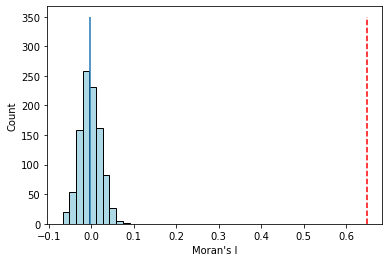

In [20]:
plt.hist(moran.sim, 10, facecolor='lightblue', edgecolor='black')
plt.vlines(moran.I, 0, 350, color='r', linestyle="--")
plt.vlines(moran.EI, 0, 350)
plt.xlabel("Moran's I")
plt.ylabel("Count")
plt.show()

The blue vertical line above is the mean value of $I$ from the permutations (from `.EI`); in this case very close to zero which indicates no spatial autocorrelation which makes sense given that the permutations are randomly generated spatial configurations of the leave vote percentage data. 

And we can see that our $I$ value of 0.65 is far greater than all value of $I$ for the permutations; this helps to confirm our intuition that our value of 0.65 is very, very unlikely to have occured by chance. 

# Local Indicators of Spatial Association <a name="lisa"></a>

The Moran's $I$ value we have seen above gives us a measure of spatial autocorrelation across the whole map for our variable of interest. It is said to be a *global* measure of spatial autocorrelation. While it can tell us in whether observations of similar values are generally clustered or dispersed, it cannot tell us *where* that clustering or dispersion is more or less pronounced across the map. 

For example, in the map of leave vote percentage (above) we might think that Scotland is a cluster of low values, while the east of England is a cluster of high values. But the global Moran's $I$ value we have calculated so far can't help us confirm or deny these suspicions. To investigate patterns like these we need to consider *local* measures of spatial autocorrelation.  

These local measures consider each individual observation and have become known as [Local Indicators of Spatial Association](http://doi.org/10.1111/j.1538-4632.1995.tb00338.x), or LISAs for short. LISAs allow us to understand how indvidual locations are related to their neighbours in ways that might be different to other locations. As we will see there are four general types:

1. *hot spots* are cluster locations with high values whose neighbours also have high values
2. *cold spots* are cluster locations with low values whose neighbours also have low values
3. *doghnuts* are outlier locations with low values surrounded by neighbours with high values
4. *diamonds* (in the rough) are outlier locations with high values surrounded by neighbours with low values

Identifying such locations also demands that we consider if local measures are statistically significant. 

## Moran Plot <a name="plot"></a>

To identify the different types of location using Moran's $I$, we need to examine how locations' values relate to the mean of their neighbours' values. As the Spatial Lag notebook showed, we can calculate the mean of neighbours' values using the `lag_spatial` function with a row-standardized spatial weights matrix:

In [21]:
gdf['Pct_Leave_lag'] = weights.spatial_lag.lag_spatial(w, gdf['Pct_Leave'])

The next step is to standardize our variable and its local mean version. That is, we calculate a z value for each variable (using the equation highlighted above):

In [22]:
def standardize(df, var):
    
    newname = var + '_z'
    df[newname] = (df[var] - df[var].mean()) / df[var].std()

standardize(gdf,'Pct_Leave')
standardize(gdf,'Pct_Leave_lag')

The function above calculates the z values which should now be contained in our GeoDataFrame (see the right two columns below):

In [23]:
gdf.tail()

,objectid,lad16nm,Pct_Leave,geometry,Pct_Leave_lag,Pct_Leave_z,Pct_Leave_lag_z
lad16cd,,,,,,,
W06000018,385,Caerphilly,57.63,"POLYGON ((-3.30131 51.79897, -3.31009 51.79430...",53.34375,0.431012,0.067468
W06000019,386,Blaenau Gwent,62.03,"POLYGON ((-3.24823 51.81515, -3.31009 51.79430...",52.79375,0.853456,0.004079
W06000021,388,Monmouthshire,49.56,"MULTIPOLYGON (((-3.05214 51.97294, -3.06736 51...",55.45875,-0.343789,0.311229
W06000022,389,Newport,55.99,"MULTIPOLYGON (((-2.83439 51.64824, -2.88647 51...",52.57750,0.273555,-0.020845
W06000023,390,Powys,53.74,"POLYGON ((-3.15484 52.89808, -3.23300 52.86699...",56.37625,0.057533,0.416974


And we can visualise how the z scores relate to the original values (i.e. the distribution hasn't changed):

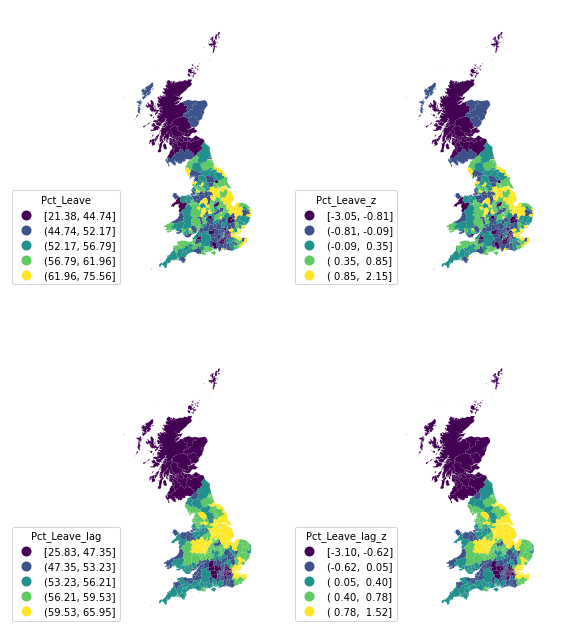

In [24]:
fig, ax = plt.subplots(2,2, figsize=(8,10))

ax=ax.flatten()

mapys = (49,62)
mapxs = (-18,4)

for i, p in enumerate(['Pct_Leave', 'Pct_Leave_z','Pct_Leave_lag','Pct_Leave_lag_z']):

    gdf.plot(column=p, cmap='viridis', 
        scheme='quantiles', k=5, 
        linewidth=0., 
        legend=True, legend_kwds={"title":p,"loc": 3},
        ax=ax[i]
       )
    ax[i].set_ylim(mapys)
    ax[i].set_xlim(mapxs)
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

To visualise the relationship between values and the means of neighbour's values (local means), we can use a scatter plot: 

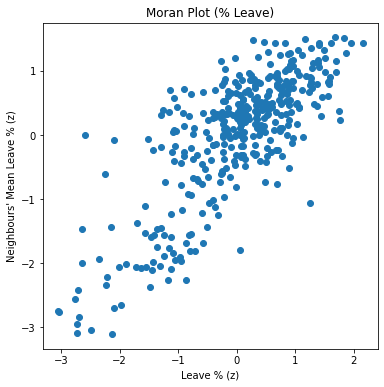

In [25]:
# Setup the figure and axis
fig, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
plt.scatter(gdf['Pct_Leave_z'], gdf['Pct_Leave_lag_z'])

# Display
ax.set_title('Moran Plot (% Leave)')
ax.set_xlabel("Leave % (z)")
ax.set_ylabel("Neighbours' Mean Leave % (z)")
plt.show()

This plot of the value of our variable of interest (in this case the vote leave %) against the means of neighbours' values is known as a *Moran Plot*. Global Moran’s I is effectively the correlation coefficient for the relationship shown in this plot. Remember our global Moran's $I$ was 0.65, indicating a positive spatial autocorrelation and we can see this pattern in the Moran Plot above. 

While Global $I$ is useful to understand the overall spatial autocorrelation in our map, to start thinking about *local* spatial autocorrelation we need to examine individual points in the scatter plot. Remember, each point in the Moran Plot is a location.

For each location, we can think about it compares to a) the overall mean of the values, and b) the overall mean of the local means (i.e. the means of neighbours' values).

Because we have standardized our values and local mean values, the overall means will be zero. So by adding lines running through zero on each axis we can now identify which of four types each point (i.e. location) belongs to:  

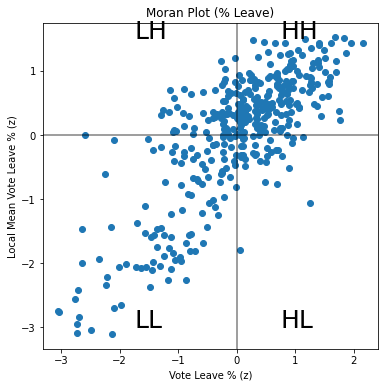

In [26]:
# Setup the figure and axis
fig, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
plt.scatter(gdf['Pct_Leave_z'], gdf['Pct_Leave_lag_z'])
# Add vertical and horizontal lines through zero
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
# Add text labels for each quadrant
plt.text(0.75, 1.5, "HH", fontsize=25)
plt.text(0.75, -3, "HL", fontsize=25)
plt.text(-1.75, 1.5, "LH", fontsize=25)
plt.text(-1.75, -3, "LL", fontsize=25)
# Display
ax.set_title('Moran Plot (% Leave)')
ax.set_xlabel("Vote Leave % (z)")
ax.set_ylabel("Local Mean Vote Leave % (z)")
plt.show()

The four types of point are:

1. HH points are above the overall mean of values *and* above the overall mean of the local means (top right)
2. LH points are below the overall mean of values *but* above the overall mean of the local means (top left)
3. LL points are below the overall mean of values *and* below the overall mean of the local means (bottom left)
4. HL points are above the overall mean of values *but* below the overall mean of the local means (bottom right)

Because each point is a location, we could map in space where the four types are located. 

To do this we first need to create a new Series in our GeoDataFrame indicating which quadrant a location is in: 

In [27]:
def rules(row):
    if row['Pct_Leave_z'] > 0:
        if row['Pct_Leave_lag_z'] > 0:
            return 'HH'  
        else:
            return 'HL'  
    else:
        if row['Pct_Leave_lag_z'] > 0:
            return 'LH'  
        else:
            return 'LL'

gdf['quadrant'] = gdf.apply(rules, 1)

And now we can create a map (and Moran Plot), using colours to indicate quandrant:

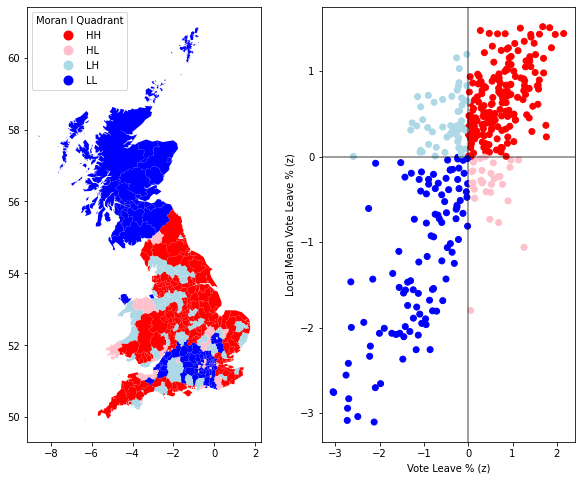

In [28]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

qcolors = {'HH':'red', 'HL':'pink', 'LH':'lightblue', 'LL':'blue'}  

#map
gdf.plot(column='quadrant', categorical=True, cmap=colors.ListedColormap(qcolors.values()),
         k=2, edgecolor='white', linewidth=0.0,
         legend=True, legend_kwds={"title":'Moran I Quadrant',"loc": 2},
         ax=ax[0])

#scatter plot
ax[1].scatter(gdf['Pct_Leave_z'], gdf['Pct_Leave_lag_z'], c=gdf['quadrant'].map(qcolors))
ax[1].axvline(0, c='k', alpha=0.5)
ax[1].axhline(0, c='k', alpha=0.5)
ax[1].set_xlabel("Vote Leave % (z)")
ax[1].set_ylabel("Local Mean Vote Leave % (z)")

plt.show()

This map helps us to see how values are grouped in space. For example, we can see areas (clusters) of similarity: areas where people tended to vote leave and so did people in neighbouring areas (red, HH) and areas where people tended to vote remain and so did people in neighbouring areas (blue, LL). But also we can see areas (outliers) of dissimilarity: areas where people tended to vote leave and people in neighbouring areas tended to vote remain (light red, HL) and areas where people tended to vote remain and people in neighbouring areas tended to vote leave (light blue, LH).  

*But* to really be sure if which areas are clusters, which are outliers, and which are neither, we need to consider statistical significance. We need to identify locations for which the comparison between its observed value (leave %) and the mean of its neighbours is either more similar (HH, LL) or dissimilar (HL, LH) **than we would expect by pure chance**. 

We can't use the single Global Moran's $I$ value to do that. Rather, we need to calculate a *Local* Moran's $I$ value for *each location*.  

## Local Moran's I <a name="local"></a>

Local Moran's $I$ for each location $j$ is given by: 

$$
I_j = \frac{z_i}{m_2} \sum{w_{ij} z_j}
$$

where:

$$
m_2 = \frac{\sum_i{z^2_i}}{n}
$$

For locations with statistically significant Local Moran's $I$ values we can then attribute locations intuitively as follows:

1. HH points are *hot spot* clusters
2. LL points are *cold spot* clusters
3. LH are *doughnut* outliers
4. HL are *diamond* outliers

To calculate Local Moran's $I$ values, we can use the PySAL [`Moran_Local` function](https://pysal.org/esda/generated/esda.Moran_Local.html), passing our variable of interest with our row-standardized spatial weights matrix:

In [29]:
lisa = esda.moran.Moran_Local(gdf['Pct_Leave'], w)

We have just calculated a Moran's $I$ value for every location in the map. These are stored in the `.Is` attribute of the `Moran_Local` object. Let's use that to create a map of the Local $I$s, first creating a new Series in our GeoDataFrame, then plotting it:

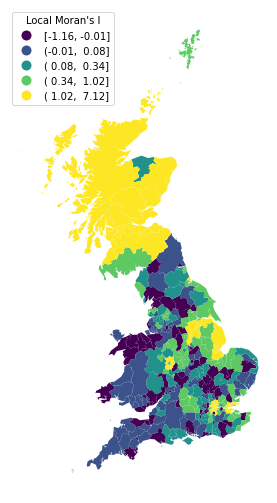

In [30]:
gdf['Is'] = lisa.Is

fig, ax = plt.subplots(1, figsize=(9, 9))
gdf.plot(column='Is', cmap='viridis', 
        scheme='quantiles', k=5, 
        linewidth=0., 
        legend=True, legend_kwds={"title":"Local Moran's I","loc": 2},
        ax=ax
       )
ax.set_axis_off()

And we can plot the distribution of the Local $I$s:

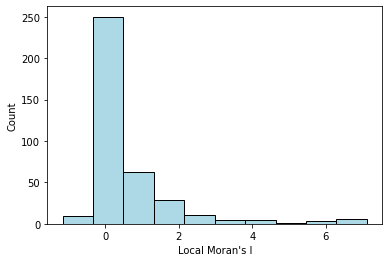

In [31]:
plt.hist(lisa.Is, 10, facecolor='lightblue', edgecolor='black')
plt.xlabel("Local Moran's I")
plt.ylabel("Count")
plt.show()

We see a skewed distribution. This is due to the dominance of the positive forms of spatial association (i.e. positive global spatial autocorrelation). 

The high positive Local $I$ values arise from similarity in space of our variable of interest - either high values being next to high values (HH) or low values next to low values (LL). But the **local $I$ values themselves cannot distinguish between HH and LL**. We'll come back to this issue below. First, we'll continue to consider the statistical significance of the $I$ values. 

As for the other PySAL functions for calculating measures of spatial autocorrelation (e.g. `Join_Counts`, `Moran`), the `Moran_Local` uses a permutation (randomisation) approach to produce a pseudo p-value *for each* of our Local $I$ values. We can plot the distribution of these too:  

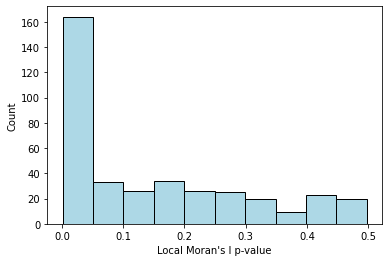

In [44]:
plt.hist(lisa.p_sim, 10, facecolor='lightblue', edgecolor='black')
plt.xlabel("Local Moran's I p-value")
plt.ylabel("Count")
plt.show()

Each p-value here indicates the the probability of incorrectly rejecting the null hypothesis of complete spatial randomness. If we decide on some level of statistical significance, we can identify which locations we believe the Local $I$ has not been arrived at by chance.  

We'll use 95% confidence here and create a new Series in our GeoDataFrame that indicates if the Local $I$ for each location is 'non-significant' or 'significant':

In [33]:
gdf['p-sim'] = lisa.p_sim

sig = 1 * (lisa.p_sim < 0.05)
slabels = ['non-sig.', 'significant'] 
labels = [slabels[i] for i in sig]

gdf['sig'] = labels
gdf[['sig','p-sim']].head(10)

,sig,p-sim
lad16cd,,
E06000001,significant,0.025
E06000002,significant,0.014
E06000003,significant,0.012
E06000004,significant,0.004
E06000010,significant,0.002
E06000011,significant,0.021
E06000032,non-sig.,0.193
E06000005,significant,0.018
E06000006,non-sig.,0.439


And now we can map those locations, with darker areas being significant and lighter areas being insignificant:

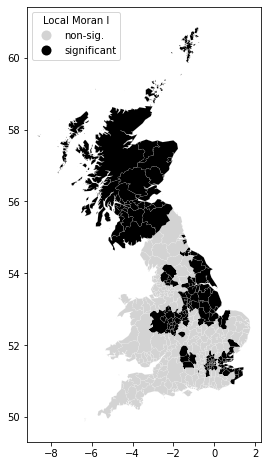

In [34]:
fig, ax = plt.subplots(1,figsize=(10,8))

sigcolors = {'non-sig.':'lightgrey', 'significant':'black'}  

gdf.plot(column='sig', categorical=True, cmap=colors.ListedColormap(sigcolors.values()),
         k=2, linewidth=0.1, edgecolor='white',
         legend=True, legend_kwds={"title":'Local Moran I',"loc": 2},
         ax=ax)
plt.show()

Now we can combine this map with our map of Local $I$s, setting non-significant locations to be a light grey colour (by first creating a new Series):

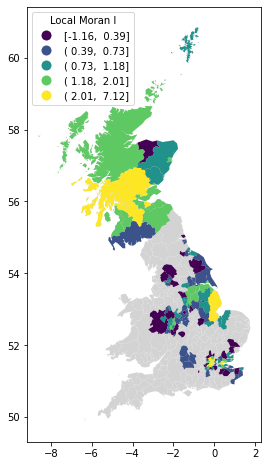

In [35]:
gdf['sigIs'] = np.where(gdf['sig'] == 'significant', gdf['Is'], np.nan)

fig, ax = plt.subplots(1, figsize=(10,8))

gdf.plot(color='lightgrey',linewidth=0.0,ax=ax)

gdf.plot(column='sigIs', cmap='viridis', scheme='quantiles',
         k=5, edgecolor='white', linewidth=0.0,
         legend=True, legend_kwds={"title":'Local Moran I',"loc": 2},
         ax=ax)
plt.show()

Now let's come back to the issue that **local $I$ values themselves cannot distinguish between HH and LL**. For example, compare maps of the Local $I$s and the quadrants:

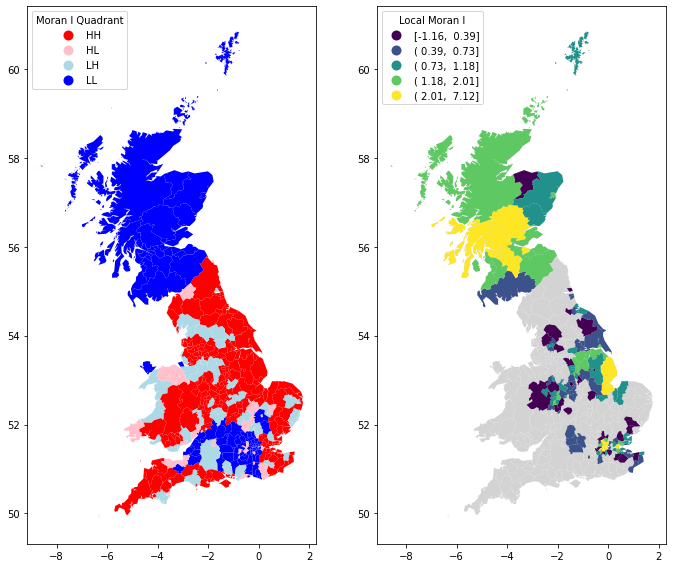

In [36]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

qcolors = {'HH':'red', 'HL':'pink', 'LL':'lightblue', 'LH':'blue'}  

gdf.plot(column='quadrant', categorical=True, cmap=colors.ListedColormap(qcolors.values()),
         k=2, edgecolor='white', linewidth=0.0,
         legend=True, legend_kwds={"title":'Moran I Quadrant',"loc": 2},
         ax=ax[0])

gdf.plot(color='lightgrey',linewidth=0.0,ax=ax[1])

gdf.plot(column='sigIs', cmap='viridis', scheme='quantiles',
         k=5, edgecolor='white', linewidth=0.0,
         legend=True, legend_kwds={"title":'Local Moran I',"loc": 2},
         ax=ax[1])

fig.tight_layout()
plt.show()

We can see see that areas with high Local $I$ (yellow) are in both HH (red) and LL (blue) quadrants. 

But what if we combine the information from the two maps above? Then we could distinguish Local $I$s using the location of the point in the Moran Plot (i.e. which quadrant it falls in). 

PySAL does this automatically for us when creating the `Moran_Local` object and we can access the quadrant info via the `.q` attribute:

In [37]:
lisa.q[1:10]

array([1, 1, 1, 1, 1, 4, 1, 1, 1])

Let's count the number of locations in each quadrant:

In [38]:
counts = [(j,(lisa.q==j).sum()) for j in range(1,5)]
counts

[(1, 181), (2, 51), (3, 112), (4, 36)]

We'll relabel the integer `.q` values to more intuitive strings: 

In [39]:
qlabels = ['HH', 'LH', 'LL', 'HL']  #pysal scheme is  HH=1, LH=2, LL=3, HL=4
labels = [qlabels[i-1] for i in lisa.q]  #list substituting 1-4 with HH-HL
labels[1:10]

['HH', 'HH', 'HH', 'HH', 'HH', 'HL', 'HH', 'HH', 'HH']

Now the counts are a little easier to interpret:

In [40]:
gdf['qlabels'] = labels
[(qlabel, (gdf['qlabels']==qlabel).sum()) for qlabel in qlabels]

[('HH', 181), ('LH', 51), ('LL', 112), ('HL', 36)]

*But* we only want to plot the significant locations. The following code assigns values 0-4 to locations:

- 0 for non-significant locations
- 1 is a hot spot (HH)
- 2 is a doughnut (LH)
- 3 is a cold spot (LL)
- 4 is a diamond (HL)

In [41]:
hotspot = 1 * (sig * lisa.q==1)
coldspot = 3 * (sig * lisa.q==3)
doughnut = 2 * (sig * lisa.q==2)
diamond = 4 * (sig * lisa.q==4)
spots = hotspot + coldspot + doughnut + diamond
spot_labels = [ '0 non-sig.', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

And now create a new Series in our GeoDataFrame using the labels we created:

In [42]:
gdf['slabels'] = labels
[(spot_label, (gdf['slabels']==spot_label).sum()) for spot_label in spot_labels]

[('0 non-sig.', 216),
 ('1 hot spot', 82),
 ('2 doughnut', 8),
 ('3 cold spot', 70),
 ('4 diamond', 4)]

Finally, we can plot our map!

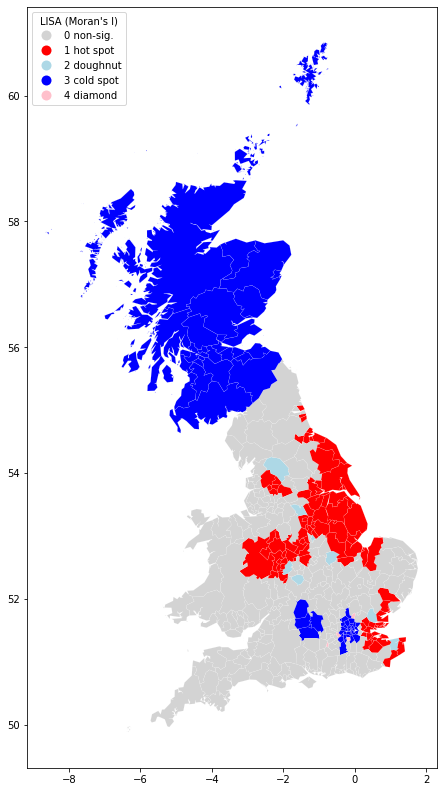

In [43]:
fig, ax = plt.subplots(1, figsize=(14,14))

sigcolors = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])

gdf.plot(column='slabels', categorical=True,
         k=2, cmap=sigcolors, linewidth=0.1, edgecolor='white', 
         legend=True, legend_kwds={"title":"LISA (Moran's I)","loc": 2},
         ax=ax)
plt.show()

Rey et al. (2020) [interpret](https://geographicdata.science/book/notebooks/07_local_autocorrelation.html) this final map nicely:

> In bright red, we find those [LADs] with an unusual concentration of high Leave proportions surrounded also by high Leave results. This corresponds with areas in the East and center of the map. 
>
> In light red, we find the first type of spatial outliers: areas that still voted to Leave in high proportions, despite being surrounded by areas with more modest support for Leave. These correspond with some of the peripheral areas of London ...
>
>In darker blue we can see the spatial clusters of low support for the Leave campaign, which include London, Oxford and most of Scotland. 
>
>Finally, in light blue we find the other type of spatial outlier: areas with lower percentages of Leave votes nearby areas of high concentration of supporters for Leave

# Credits!

## Contributors:
The following individual(s) have contributed to these teaching materials: James Millington (james.millington@kcl.ac.uk).

## License
These teaching materials are licensed under a mix of [The MIT License](https://opensource.org/licenses/mit-license.php) and the [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 license](https://creativecommons.org/licenses/by-nc-sa/4.0/).